In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [3]:
azul_df = pd.read_excel('data\AZUL.xlsx',index_col=0)
azul_df.index = pd.to_datetime(azul_df.index)

<AxesSubplot: xlabel='Data'>

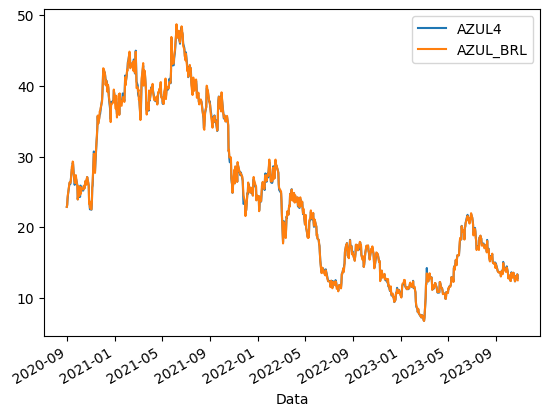

In [4]:
azul_pair = azul_df[['AZUL4', 'AZUL_BRL']]
azul_pair.plot()

In [58]:

# A = pd.Series(np.cumsum(np.random.normal(size=766, scale=1)) + 50, name='A', index=azul_pair.index)
# B = pd.Series(A + 20 + np.random.normal(size=766, scale=1), name='B',index=azul_pair.index)

# azul_pair = pd.concat([A, B], axis=1)

# azul_pair.plot()

In [5]:
insample = azul_pair.loc[:'2022']
outofsample = azul_pair.loc['2022':]

# insample.plot()
# outofsample.plot()

<AxesSubplot: xlabel='Data'>

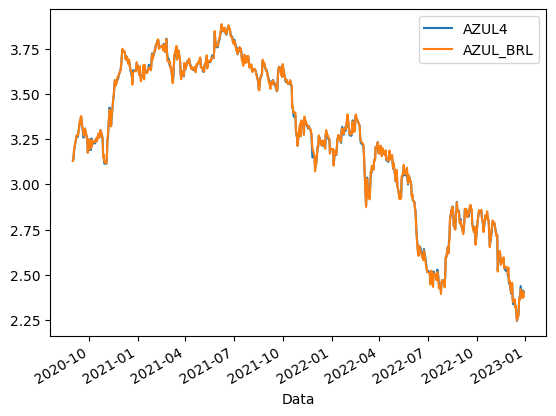

In [6]:
np.log(insample).plot()

### VECM Model 

In [7]:
from statsmodels.tsa.vector_ar.vecm import VECM, select_coint_rank, select_order

In [8]:
import warnings


warnings.filterwarnings('ignore')
order = select_order(np.log(insample), deterministic='n', maxlags=10)
order.selected_orders

{'aic': 4, 'bic': 0, 'hqic': 0, 'fpe': 4}

In [9]:
rank_test = select_coint_rank(np.log(insample), det_order=-1, k_ar_diff=1, signif=0.1, method='maxeig')
rank_test.rank

1

In [10]:
vecm = VECM(np.log(insample),  coint_rank=rank_test.rank, # 1 relação de cointegração de acordo com o teste de Johansen
            k_ar_diff=3, #3 lags autoregressivos
            deterministic = 'co').fit()

vecm.summary()

,coef,std err,z,P>|z|,[0.025,0.975]
const,-0.0044,0.002,-1.941,0.052,-0.009,4.4e-05
L1.AZUL4,-0.5389,0.313,-1.722,0.085,-1.152,0.074
L1.AZUL_BRL,0.5541,0.304,1.821,0.069,-0.042,1.151
L2.AZUL4,-0.4855,0.272,-1.783,0.075,-1.019,0.048
L2.AZUL_BRL,0.4520,0.265,1.704,0.088,-0.068,0.972
L3.AZUL4,-0.0241,0.211,-0.114,0.909,-0.437,0.389
L3.AZUL_BRL,0.0663,0.204,0.326,0.745,-0.333,0.465
,coef,std err,z,P>|z|,[0.025,0.975]
const,-0.0074,0.002,-3.061,0.002,-0.012,-0.003
L1.AZUL4,-0.3063,0.331,-0.925,0.355,-0.956,0.343


In [11]:
ljungbox = vecm.test_whiteness()
ljungbox.summary()

Test statistic,Critical value,p-value,df
30.42,38.89,0.251,26


$$
\Delta p^{AZUL} = 0.2260 + -0.876*(1p_{t-1}^{AZUL} - 0.993 p_{t-1}^{AZUL4}) -0.276p_{t-1}^{AZUL4} +0.275p_{t-1}^{AZUL}
$$
$$
\Delta p^{AZUL4} = -0.0019 + 0.022*(1p_{t-1}^{AZUL} - 0.993 p_{t-1}^{AZUL4}) +0.250p_{t-1}^{AZUL4} -0.263p_{t-1}^{AZUL}
$$

In [12]:
spread = azul_pair['AZUL4'] +vecm.beta[1]*azul_pair['AZUL_BRL']

<AxesSubplot: xlabel='Data'>

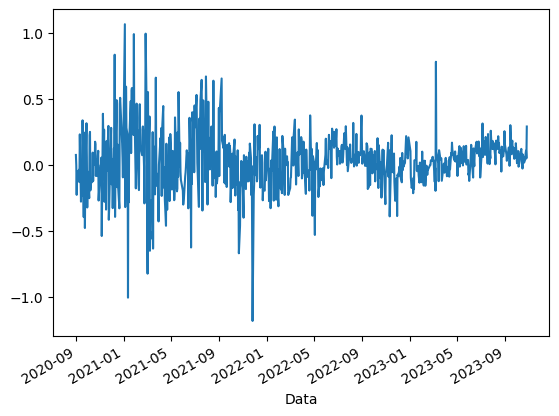

In [13]:
spread.plot()

<AxesSubplot: xlabel='Data'>

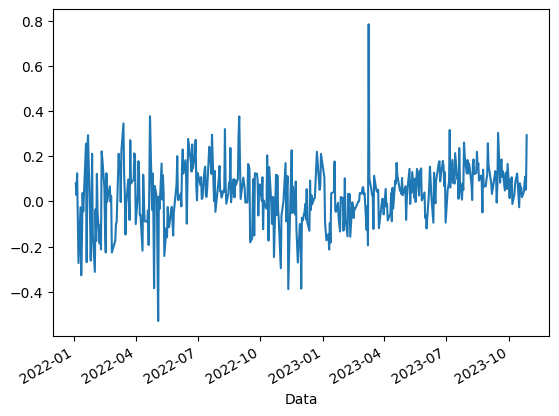

In [14]:
spread.loc[outofsample.index].plot()

In [15]:
import pandas_ta as ta

std_spread = (spread - spread.mean())/spread.std()
std_spread = spread.to_frame()

bolinger = ta.bbands(close=std_spread.iloc[:,0], length=50, std=2)

std_spread['Lower'] = bolinger.iloc[:, 0]
std_spread['Mean'] = bolinger.iloc[:, 1]
std_spread['Upper'] = bolinger.iloc[:, 2]


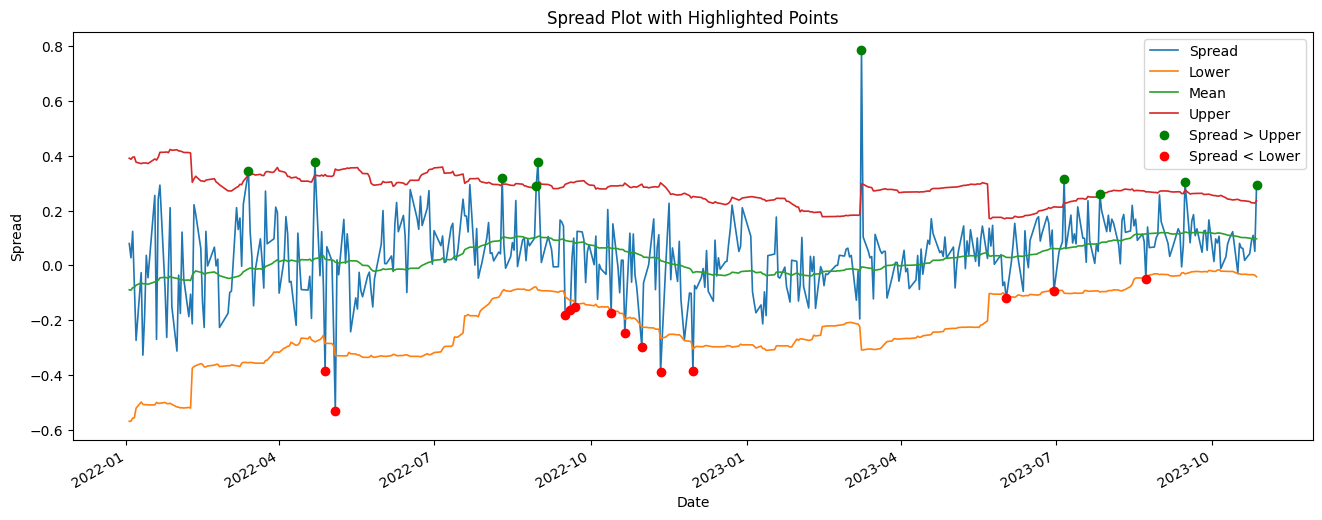

In [16]:
oos_spread = std_spread.loc['2022':]
oos_spread.rename(columns={0: 'Spread'}, inplace=True)

oos_spread.plot(figsize=(16,6),  linewidth=1.2)

plt.scatter(oos_spread.index[oos_spread['Spread'] > oos_spread['Upper']], oos_spread['Spread'][oos_spread['Spread'] > oos_spread['Upper']],
            color='green', label='Spread > Upper', zorder=2)

# Highlight red points when Spread < Lower
plt.scatter(oos_spread.index[oos_spread['Spread'] < oos_spread['Lower']], oos_spread['Spread'][oos_spread['Spread'] < oos_spread['Lower']],
            color='red', label='Spread < Lower', zorder=2)

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Spread')
plt.legend()
plt.title('Spread Plot with Highlighted Points')

# Show the plot
plt.show()

In [17]:
oos_spread

,Spread,Lower,Mean,Upper
Data,,,,
2022-01-03,0.079826,-0.568450,-0.088652,0.391147
2022-01-04,0.027998,-0.567886,-0.090339,0.387209
2022-01-05,0.124344,-0.556862,-0.081048,0.394766
2022-01-06,-0.069516,-0.555579,-0.079926,0.395727
2022-01-07,-0.273276,-0.520567,-0.072008,0.376552
...,...,...,...,...
2023-10-23,0.043168,-0.033982,0.099478,0.232939
2023-10-24,0.088703,-0.033644,0.097533,0.228710
2023-10-25,0.109971,-0.033741,0.097318,0.228377


In [18]:
AZUL_level = outofsample['AZUL_BRL']

df_sinais = pd.concat((oos_spread,AZUL_level.rename('Close')), axis=1)
df_sinais['Buy'] = np.where(oos_spread['Spread'] > oos_spread['Upper'], 1, 0)
df_sinais['Sell'] = np.where(oos_spread['Spread'] <  oos_spread['Lower'], 1, 0)
df_sinais['Sell'] = df_sinais['Sell'].diff()
df_sinais['Buy'] = df_sinais['Buy'].diff()
df_sinais.dropna(inplace=True)

In [133]:
AZUL_level = outofsample['AZUL4']

df_sinais = pd.concat((oos_spread,AZUL_level.rename('Close')), axis=1)
df_sinais['Sell'] = np.where(oos_spread['Spread'] > oos_spread['Upper'], 1, 0)
df_sinais['Buy'] = np.where(oos_spread['Spread'] <  oos_spread['Lower'], 1, 0)
df_sinais['Sell'] = df_sinais['Sell'].diff()
df_sinais['Buy'] = df_sinais['Buy'].diff()
df_sinais.dropna(inplace=True)

In [19]:
df_sinais[(df_sinais['Buy']==1) | (df_sinais['Sell']==1)]

,Spread,Lower,Mean,Upper,Close,Buy,Sell
Data,,,,,,,
2022-03-14,0.345403,-0.354579,-0.012207,0.330165,18.486155,1.0,0.0
2022-04-22,0.377332,-0.278879,0.025041,0.328961,23.031987,1.0,0.0
2022-04-28,-0.384379,-0.285031,0.023281,0.331593,22.633017,0.0,1.0
2022-05-04,-0.529917,-0.328059,0.011756,0.351570,21.757060,0.0,1.0
2022-08-10,0.320138,-0.095057,0.101609,0.298276,14.324316,1.0,0.0
2022-08-30,0.289681,-0.079166,0.101702,0.282570,16.248057,1.0,0.0
2022-09-16,-0.181338,-0.113984,0.090891,0.295766,17.010377,0.0,1.0
2022-09-22,-0.151400,-0.143453,0.080792,0.305037,17.501277,0.0,1.0
2022-10-13,-0.173718,-0.165907,0.062288,0.290483,16.311564,0.0,1.0


In [51]:
def simulate_trades(df):
    trades = []
    open_trades = []
    
    # enter condition
    for index, row in df.iterrows():
        if row['Buy'] == 1:
            new_trade = {'type':'buy', 'entry_date': index, 'entry_price': row['Close'],'entry_spread': row['Spread'],'entry_mean': row['Mean']}
            open_trades.append(new_trade)
        elif row['Sell'] == 1:
            new_trade = {'type':'sell', 'entry_date': index,'entry_price': row['Close'], 'entry_spread': row['Spread'],'entry_mean': row['Mean']}
            open_trades.append(new_trade)

    for trade in open_trades:

        #exit condition
        df_trade = df.loc[trade['entry_date']:][1:]
        
        for index, row in df_trade.iterrows():
            if (row['Spread'] > row['Mean'] )!= (trade['entry_spread'] > trade['entry_mean']):
                trade['exit_date'] = index
                trade['exit_price'] = row['Close']
                trade['exit_spread'] = row['Spread']
                
                if trade['type'] == 'buy':
                    trade['return (%)'] = (trade['exit_price'] - trade['entry_price'])/ trade['entry_price']*100
                elif trade['type'] == 'sell':
                    trade['return (%)'] = (trade['entry_price'] -  trade['exit_price'])/ trade['entry_price']*100
                break
            
        trades.append(trade)

    return pd.DataFrame(trades).sort_values('entry_date', ascending=True)

# Example usage:
# Assuming your DataFrame is named 'df'
trades_df = simulate_trades(df_sinais)
trades_df = trades_df.dropna()

In [59]:
trades_df


,type,entry_date,entry_price,entry_spread,entry_mean,exit_date,exit_price,exit_spread,return (%)
0,buy,2022-03-14,18.486155,0.345403,-0.012207,2023-10-26,13.331315,0.051443,-27.884868
1,buy,2022-04-22,23.031987,0.377332,0.025041,2023-10-26,13.331315,0.051443,-42.118258
2,sell,2022-04-28,22.633017,-0.384379,0.023281,2023-10-27,12.518440,0.292931,44.689477
3,sell,2022-05-04,21.757060,-0.529917,0.011756,2023-10-27,12.518440,0.292931,42.462630
4,buy,2022-08-10,14.324316,0.320138,0.101609,2023-10-26,13.331315,0.051443,-6.932273
5,buy,2022-08-30,16.248057,0.289681,0.101702,2023-10-26,13.331315,0.051443,-17.951328
6,sell,2022-09-16,17.010377,-0.181338,0.090891,2023-10-27,12.518440,0.292931,26.407038
7,sell,2022-09-22,17.501277,-0.151400,0.080792,2023-10-27,12.518440,0.292931,28.471278
8,sell,2022-10-13,16.311564,-0.173718,0.062288,2023-10-27,12.518440,0.292931,23.254200
9,sell,2022-10-21,17.306333,-0.246789,0.051950,2023-10-27,12.518440,0.292931,27.665556


<AxesSubplot: >

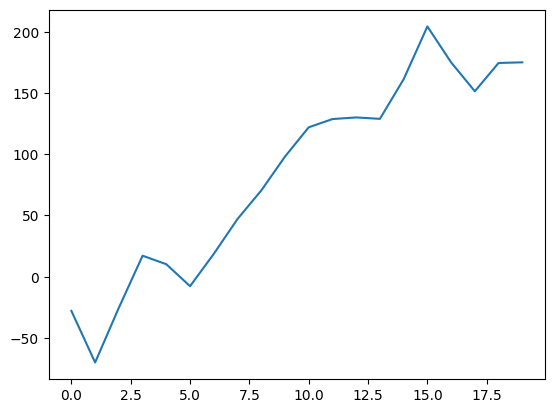

In [58]:
trades_df['return (%)'].cumsum().plot()

<AxesSubplot: xlabel='Data'>

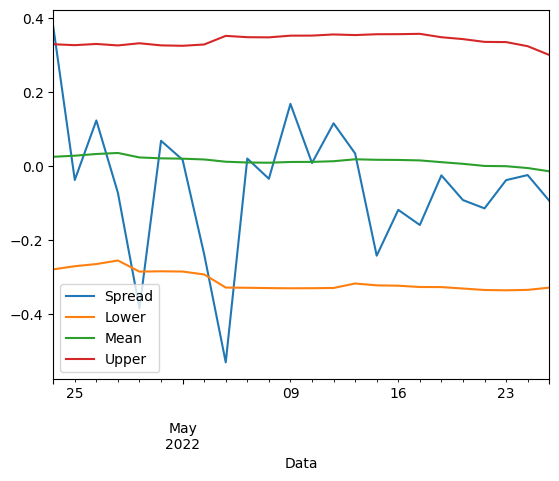

In [53]:
oos_spread.loc['2022-04-22':'2022-05-25'].plot()